## CO2 atmospheric level prediction: Using ARIMA and SARIMA

In [1]:
# Loading the required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [2]:
# Loading the dataset
co2 = sm.datasets.co2.load_pandas()
df_co2 = co2.data
print(df_co2.head())

              co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4


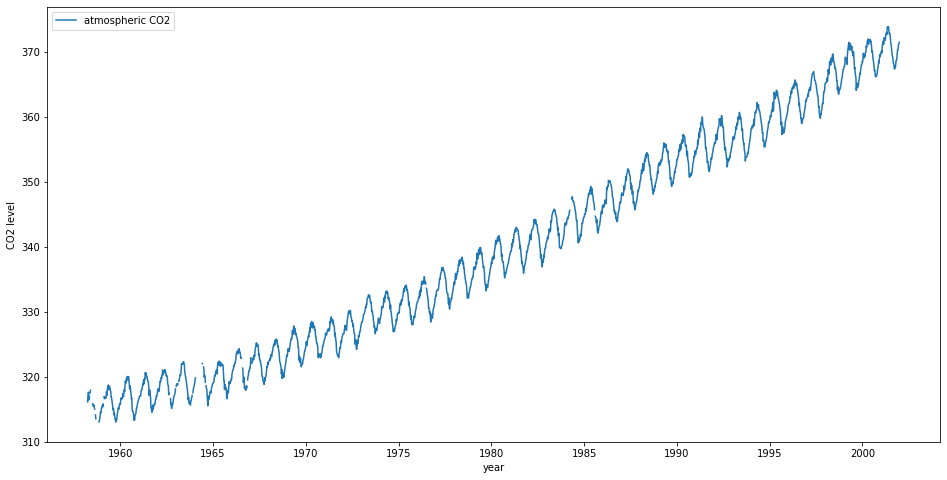

In [3]:
plt.figure(figsize = (16,8))
plt.plot(df_co2, label = 'atmospheric CO2')
plt.xlabel('year')
plt.ylabel('CO2 level')
plt.legend(loc = 'best')
plt.show()

In [4]:
#Checking for missing values 
print(df_co2.isna().sum())
#treating na values
#replacing the na value with previour terms value
df_co2.fillna(df_co2.bfill(), inplace = True)

co2    59
dtype: int64


In [5]:
#splitting the data into Train and Test datasets
df_co2.reset_index(inplace = True)
df_co2.columns = ['date', 'co2']
df_co2['date'] = pd.to_datetime(df_co2['date'])
df_co2.min(), df_co2.max()

(date    1958-03-29 00:00:00
 co2                     313
 dtype: object,
 date    2001-12-29 00:00:00
 co2                   373.9
 dtype: object)

In [6]:
# splitting the data trainning and testing
train = df_co2[df_co2['date'] <'1998-01-01']

#last 3 years data for testing
test = df_co2[df_co2['date']>='1998-01-01']
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

### Arima Model

In [17]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [11]:
def check_stationarity(ts):
    rol_mean = ts.rolling(52).mean()
    rol_std = ts.rolling(52).std()
    orig = plt.plot(ts, color='blue', label = 'Data')
    mean = plt.plot(rol_mean, color = 'red', label = 'rolling mean')
    plt.legend(loc='best')

    test_res = adfuller(ts, autolag='AIC')
    output = pd.Series(test_res[0:4], index = ['Test Stats', 'P-value', '#lags', 'Number of obs'])
    for key, value in test_res[4].items():
        output['Critical value (%s)'%key] = value
    print(output)

Test Stats                -0.204349
P-value                    0.938001
#lags                     26.000000
Number of obs           2048.000000
Critical value (1%)       -3.433547
Critical value (5%)       -2.862952
Critical value (10%)      -2.567522
dtype: float64


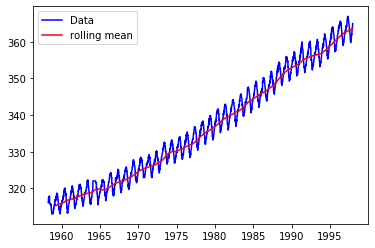

In [15]:
check_stationarity(train)

Test Stats             -1.866524e+01
P-value                 2.046363e-30
#lags                   2.600000e+01
Number of obs           1.997000e+03
Critical value (1%)    -3.433629e+00
Critical value (5%)    -2.862988e+00
Critical value (10%)   -2.567541e+00
dtype: float64


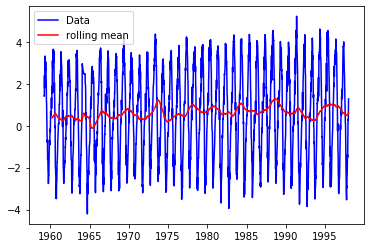

In [14]:
#removing trend 
moving_avg = train.rolling(52).mean()
stationary_train = train - moving_avg
check_stationarity(stationary_train.dropna())

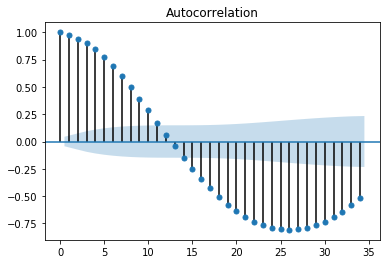

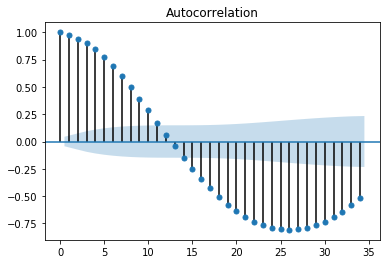

In [20]:
# ACF and PACF plots
plot_acf(stationary_train.dropna())

This indicates 10 is a good number to start with

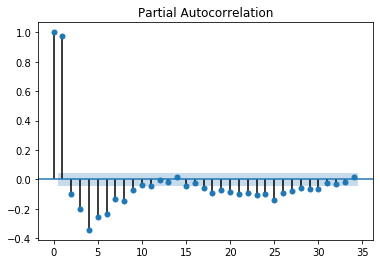

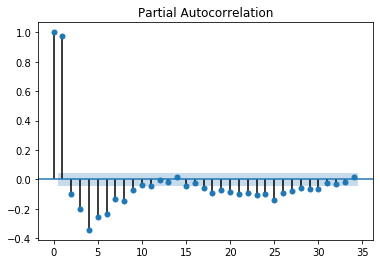

In [21]:
#Pacf plot
plot_pacf(stationary_train.dropna())

we can try with 2, 3, 4, 5

In [56]:
model = ARIMA(train, order = (10, 1, 2))

C:\Users\hkpat\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\hkpat\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)


In [57]:
result_arima = model.fit()

In [58]:
result_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.co2   No. Observations:                 2074
Model:                ARIMA(10, 1, 2)   Log Likelihood               -1100.230
Method:                       css-mle   S.D. of innovations              0.411
Date:                Sun, 13 Sep 2020   AIC                           2228.460
Time:                        17:57:11   BIC                           2307.382
Sample:                    04-05-1958   HQIC                          2257.385
                         - 12-27-1997                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0241      0.003      7.950      0.000       0.018       0.030
ar.L1.D.co2      1.7202      0.022     76.660      0.000       1.676       1.764
ar.L2.D.co2     -0.6132      0.044    -13.895      0.000      -0.700      -0.527
ar.L3.D.co2      0.0905      0.046      1.977      0.048       0.001       0.180
ar.L4.D.co2     -0.2253      0.045     -5.034      0.000      -0.313      -0.138
ar.L5.D.co2      0.0314      0.044      0.716      0.474      -0.055       0.117
ar.L6.D.co2     -0.1010      0.045     -2.248      0.025      -0.189      -0.013
ar.L7.D.co2      0.1010      0.046      2.199      0.028       0.011       0.191
ar.L8.D.co2     -0.0852      0.047     -1.822      0.069      -0.177       0.006
ar.L9.D.co2      0.0941      0.045      2.104      0.035       0.006       0.182
ar.L10.D.co2    -0.0287      0.023     -1.271      0.204      -0.073       0.016
ma.L1.D.co2     -1.9793      0.004   -484.065      0.000      -1.987      -1.971
ma.L2.D.co2      0.9848      0.004    241.781      0.000       0.977       0.993
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.2407           -0.6382j            1.3952           -0.4244
AR.2            -1.2407           +0.6382j            1.3952            0.4244
AR.3            -0.5062           -1.3766j            1.4667           -0.3061
AR.4            -0.5062           +1.3766j            1.4667            0.3061
AR.5             0.9959           -0.1216j            1.0033           -0.0193
AR.6             0.9959           +0.1216j            1.0033            0.0193
AR.7             0.4709           -1.4528j            1.5272           -0.2001
AR.8             0.4709           +1.4528j            1.5272            0.2001
AR.9             1.5422           -0.0000j            1.5422           -0.0000
AR.10            2.3013           -0.0000j            2.3013           -0.0000
MA.1             1.0050           -0.0741j            1.0077           -0.0117
MA.2             1.0050           +0.0741j            1.0077            0.0117
------------------------------------------------------------------------------
"""

#### Residual analysis

In [59]:
result_arima.resid

date
1958-04-05    1.175909
1958-04-12    0.203025
1958-04-19   -0.322795
1958-04-26   -1.503877
1958-05-03    0.130636
                ...   
1997-11-29    0.664399
1997-12-06    0.283529
1997-12-13   -0.187908
1997-12-20   -0.120378
1997-12-27    0.386399
Length: 2074, dtype: float64

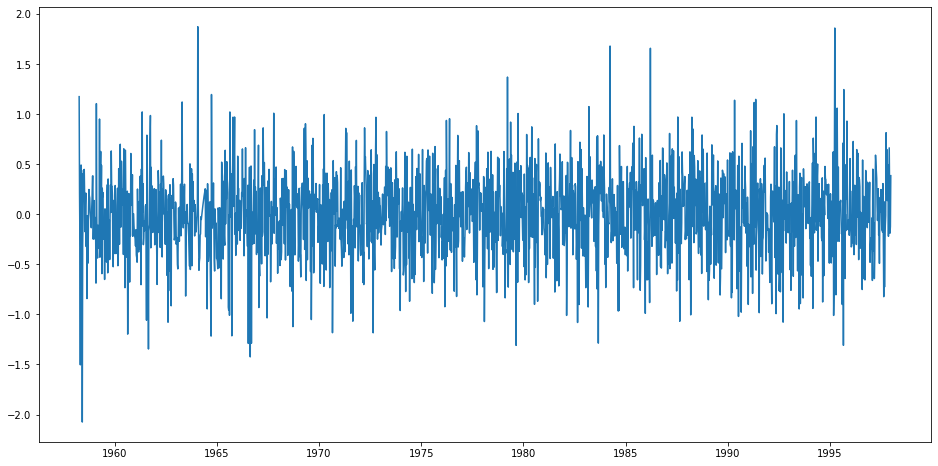

In [60]:
plt.figure(figsize = (16, 8))
plt.plot(result_arima.resid)

There is no trend in the residuls, the parameters have been tuned

#### Forecasting for the last 3 months

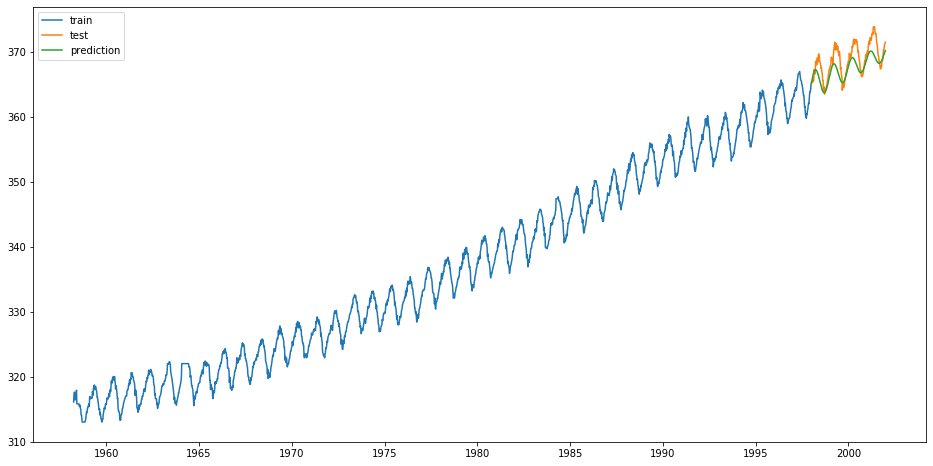

In [61]:
y_pred = test.copy()
y_pred['arima'] = result_arima.forecast(len(test))[0]
plt.figure(figsize = (16, 8))
plt.plot(train['co2'], label ='train')
plt.plot(test['co2'], label = 'test')
plt.plot(y_pred['arima'], label='prediction')
plt.legend(loc = 'best')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['co2'], y_pred['arima']))

1.9949410136998291

In [62]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['co2'], y_pred['arima']))

1.9808181557391973

### SARIMAX

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [64]:
model = SARIMAX(train, order = (10, 1, 2), seasonal_order=(0, 1, 1, 52))
model_fcst = model.fit()

C:\Users\hkpat\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\hkpat\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\hkpat\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


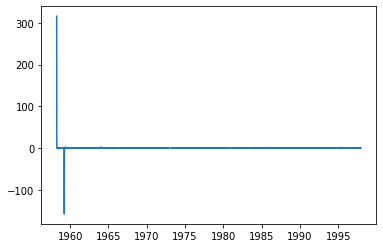

In [68]:
plt.plot(model_fcst.resid)

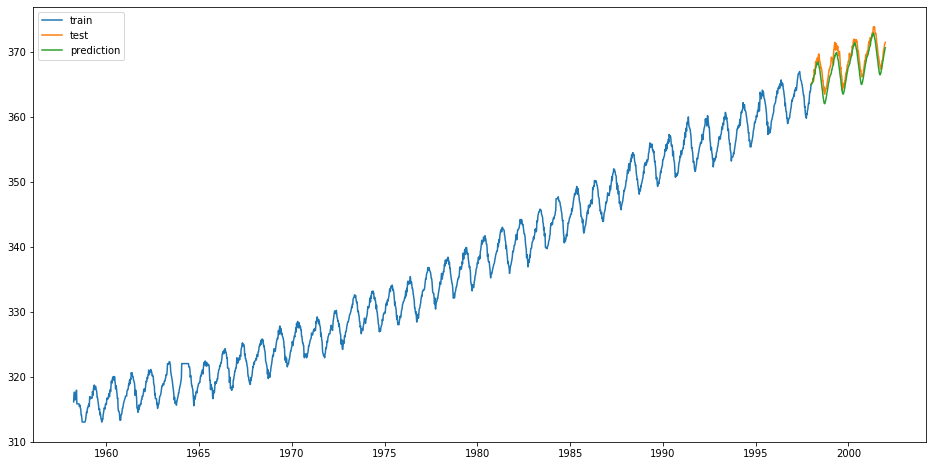

In [70]:
y_pred['sarima'] = model_fcst.forecast(len(test))
plt.figure(figsize = (16, 8))
plt.plot(train['co2'], label ='train')
plt.plot(test['co2'], label = 'test')
plt.plot(y_pred['sarima'], label='prediction')
plt.legend(loc = 'best')
plt.show()

In [72]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['co2'], y_pred['sarima']))

1.264494011854129